In [2]:
from gensim.models import LdaModel
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from langid import set_languages, classify
set_languages(['nl', 'en'])

df_grote_word_doc = pd.read_json(r'C:\Users\johan\Documents\GitHub\portfolio\NLP\data\NLP for grote word-file.json')

In [3]:
# choose a number of topics
num_topics = 4

# preprocessing, stopwords, ngrams, lemmatization

In [4]:
data = df_grote_word_doc.text.values.tolist()

def sent_to_words(texts):
    for text in texts:
        sent = gensim.utils.simple_preprocess(str(text), deacc=True, min_len=3) 
        yield(sent)

# Convert to list
data_words = list(sent_to_words(data))

stop_words = stopwords.words('dutch') + stopwords.words('english') 
more_words = ['vooral', 'gaan', 'één', 'value', 'part', 'use', 'blijven', 'waarbij', 'stuk', 'wanneer', 'much', 'kennen', 'always', 'tegelijk', 'however', 'geven', 'nooit', 'weg', 'vaak', 'soort', 'wellicht', 'leggen', 'steken', 'leven', 'zoal,', 'waar', 'allemaal', 'net', 'eigen', 'stefaf', 'vallen', 'zaak', 'feit', 'waaruit', 'zelfs', 'year', 'echter', 'zien', 'come', 'willen', 'spreken', 'straf', 'lijken', 'staan', 'even', 'hoog', 'pas', 'liggen', 'waarom', 'helemaal', 'situatie', 'waaraan', 'zitten', 'take', 'waarin', 'often', 'wel', 'maken', 'nieuw', 'waarop', 'plots', 'say', 'goed', 'way', 'terug', 'mogelijk', 'many', 'daarom', 'omwille', 'leren', 'nemen', 'kijken', 'waarde', 'gebruiken', 'iphone', 'eerder', 'weer', 'zoeken', 'dienen', 'alleen', 'houden', 'see', 'well', 'good', 'deel', 'find', 'misschien', 'make', 'vinden', 'also', 'manier', 'natuurlijk', 'laten', 'louter', 'komen', 'stellen', 'ergens', 'live', 'ver', 'daarentegen', 'facebook', 'steeds', 'time', 'need', 'enkel', 'new', 'nodig', 'vormen', 'halen', 'duidelijk', 'zeggen', 'camera', 'krijgen', 'brengen', 'eigenlijk', 'proberen', 'gewoon', 'heel', 'zeer', 'telkens', 'look', 'eerst', 'belangrijk', 'nochtans', 'waarmee', 'lang', 'zeker']
more_words = list(set(more_words))
stop_words = set(stop_words + more_words)

# check language, lemmatize, remove stopwords
def process_lang_multi(mails, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """language detection and Lemmatization"""
    
    mails = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in mails]
    
    texts_out = []
    
    nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp_nl = spacy.load("nl_core_news_sm", disable=['parser', 'ner'])
    
    for mail in mails:
        mail_text = []
        for i in range(0, len(mail) - 2, 3):
            term = mail[i] + " " + mail[i+1] + " " + mail[i+2]
            lang, _ = classify(term)
            if lang == 'nl':
                doc = nlp_nl(term) 
            else:
                doc = nlp_en(term) 
            
            mail_text.extend(doc)
                        
        texts_out.append([token.lemma_ for token in mail_text if token.pos_ in allowed_postags])
            
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    return texts_out

# DUTCH only, lemmatize, remove stopwords
def process_lang(mails, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """language detection and Lemmatization"""
    
    mails = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in mails]
    
    texts_out = []
    
    # nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp_nl = spacy.load("nl_core_news_sm", disable=['parser', 'ner'])
    
    for mail in mails:
        mail_text = []
        for i in range(0, len(mail) - 2, 3):
            term = mail[i] + " " + mail[i+1] + " " + mail[i+2]
            lang, _ = classify(term)
            if lang == 'nl':
                doc = nlp_nl(term) 
            # else:
            #     doc = nlp_en(term) 
                mail_text.extend(doc)
                        
        texts_out.append([token.lemma_ for token in mail_text if token.pos_ in allowed_postags])
            
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    return texts_out

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_ngrams(texts, stop_words=stop_words):
    """Remove Stopwords, Form Bigrams, Trigrams"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    return texts

In [5]:
# this does ALL the preprocessing (takes time)
data_ready = process_ngrams(data_words)
data_words = process_lang(data_words)

id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# alternatively, I can store/load the trained model

# lda_model = LdaModel.load(r"C:\Users\johan\Documents\GitHub\sandbox\NLP\data\word_file_lda")

## training LDA

In [6]:
lda_model = models.LdaModel(corpus=corpus,
                            id2word=id2word,
                            num_topics=num_topics, 
                            random_state=75,
                            chunksize=350, # 20 is too low and 800 too high
                            passes=35,
                            iterations=10,
                            eta='auto', 
                            alpha='auto', 
                            eval_every=5,
                            per_word_topics=True
                            )

## visualising and analysing LDA

In [19]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.216690 -0.161152       1        1  59.128417
1      0.059540  0.144298       2        1  15.506296
3     -0.276416 -0.095173       3        1  15.288720
0      0.000186  0.112027       4        1  10.076567, topic_info=              Term        Freq       Total Category  logprob  loglift
75            onze  420.000000  420.000000  Default  30.0000  30.0000
321         mensen  648.000000  648.000000  Default  29.0000  29.0000
1079        people  132.000000  132.000000  Default  28.0000  28.0000
3219          like  127.000000  127.000000  Default  27.0000  27.0000
7657           one  100.000000  100.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1179           via   16.440076  102.688992   Topic4  -6.7588   0.4630
1597         blogs   14.601792   49.508601   Topic4  -6.8774   1.0740
361        cultuur   15.443242  113.690427   Topic4  -6.8214   0.2986
1682  persoonlijke   14.587358   83.957893   Topic4  -6.8784   0.5448
1027         grote   14.330677  143.505178   Topic4  -6.8961  -0.0090

[225 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6681      4  0.967351  aantal
1940      4  0.973569   aarde
3         1  0.755643    alle
3         2  0.218297    alle
3         4  0.025188    alle
...     ...       ...     ...
404       1  0.997151     zin
546       1  0.847176   zoals
546       2  0.149822   zoals
550       1  0.505601  zullen
550       2  0.491557  zullen

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [8]:
import pandas as pd

# to show more characters
pd.options.display.max_colwidth = 100

Dominant topic and its percentage contribution in each email

In [9]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic,4), topic_keywords]], columns=sent_topics_df.columns)
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break
            
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df_grote_word_doc.text.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Email_onderwerp']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Email_onderwerp
0,0,2,0.5380,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",
1,1,2,0.5380,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",
2,2,2,0.9982,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen","Wat ik hier wil doen is, net als in mijn dagboek van een auteur, een discours ontwikkelen voor e..."
3,3,2,0.5380,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",
4,4,2,0.8904,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",Bepaalde vragen rond structuur en verhaallijn houden mij bezig. Kan een realisme volstaan? Wordt...
5,5,2,0.9948,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen","Drugs, ziekte en gemoed. Wat ik wil doen is in zekere zin de stemmingen laten spreken. Stemminge..."
6,6,2,0.7454,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",Zelfrelativering. Het is een notie die het overdenken waard is. Zonet kwam ik tot deze conclusie...
7,7,2,0.9352,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",Wat is taal? Taal is als lijn die boven de treinsporen loopt en de machinerie van energie voorzi...
8,8,2,0.7246,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",Voorfilosofisch. Wat zijn de gedachten die mij bezighielden voor ik filosofie ging studeren? Wat...
9,9,2,0.9947,"mensen, wereld, gaat, zoals, denken, lijkt, liefde, iedereen, onze, dingen",Een boek met een boodschap. Ik ben mooi en verstandig en neem er genoegen mee. Het is een bijzon...


In [ ]:
df_dominant_topic.Keywords.unique()

## Find the most representative document for each topic

In [10]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                    grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                   axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Email_onderwerp"]

# Show
# sent_topics_sorted

Frequency Distribution of Word Counts in Documents

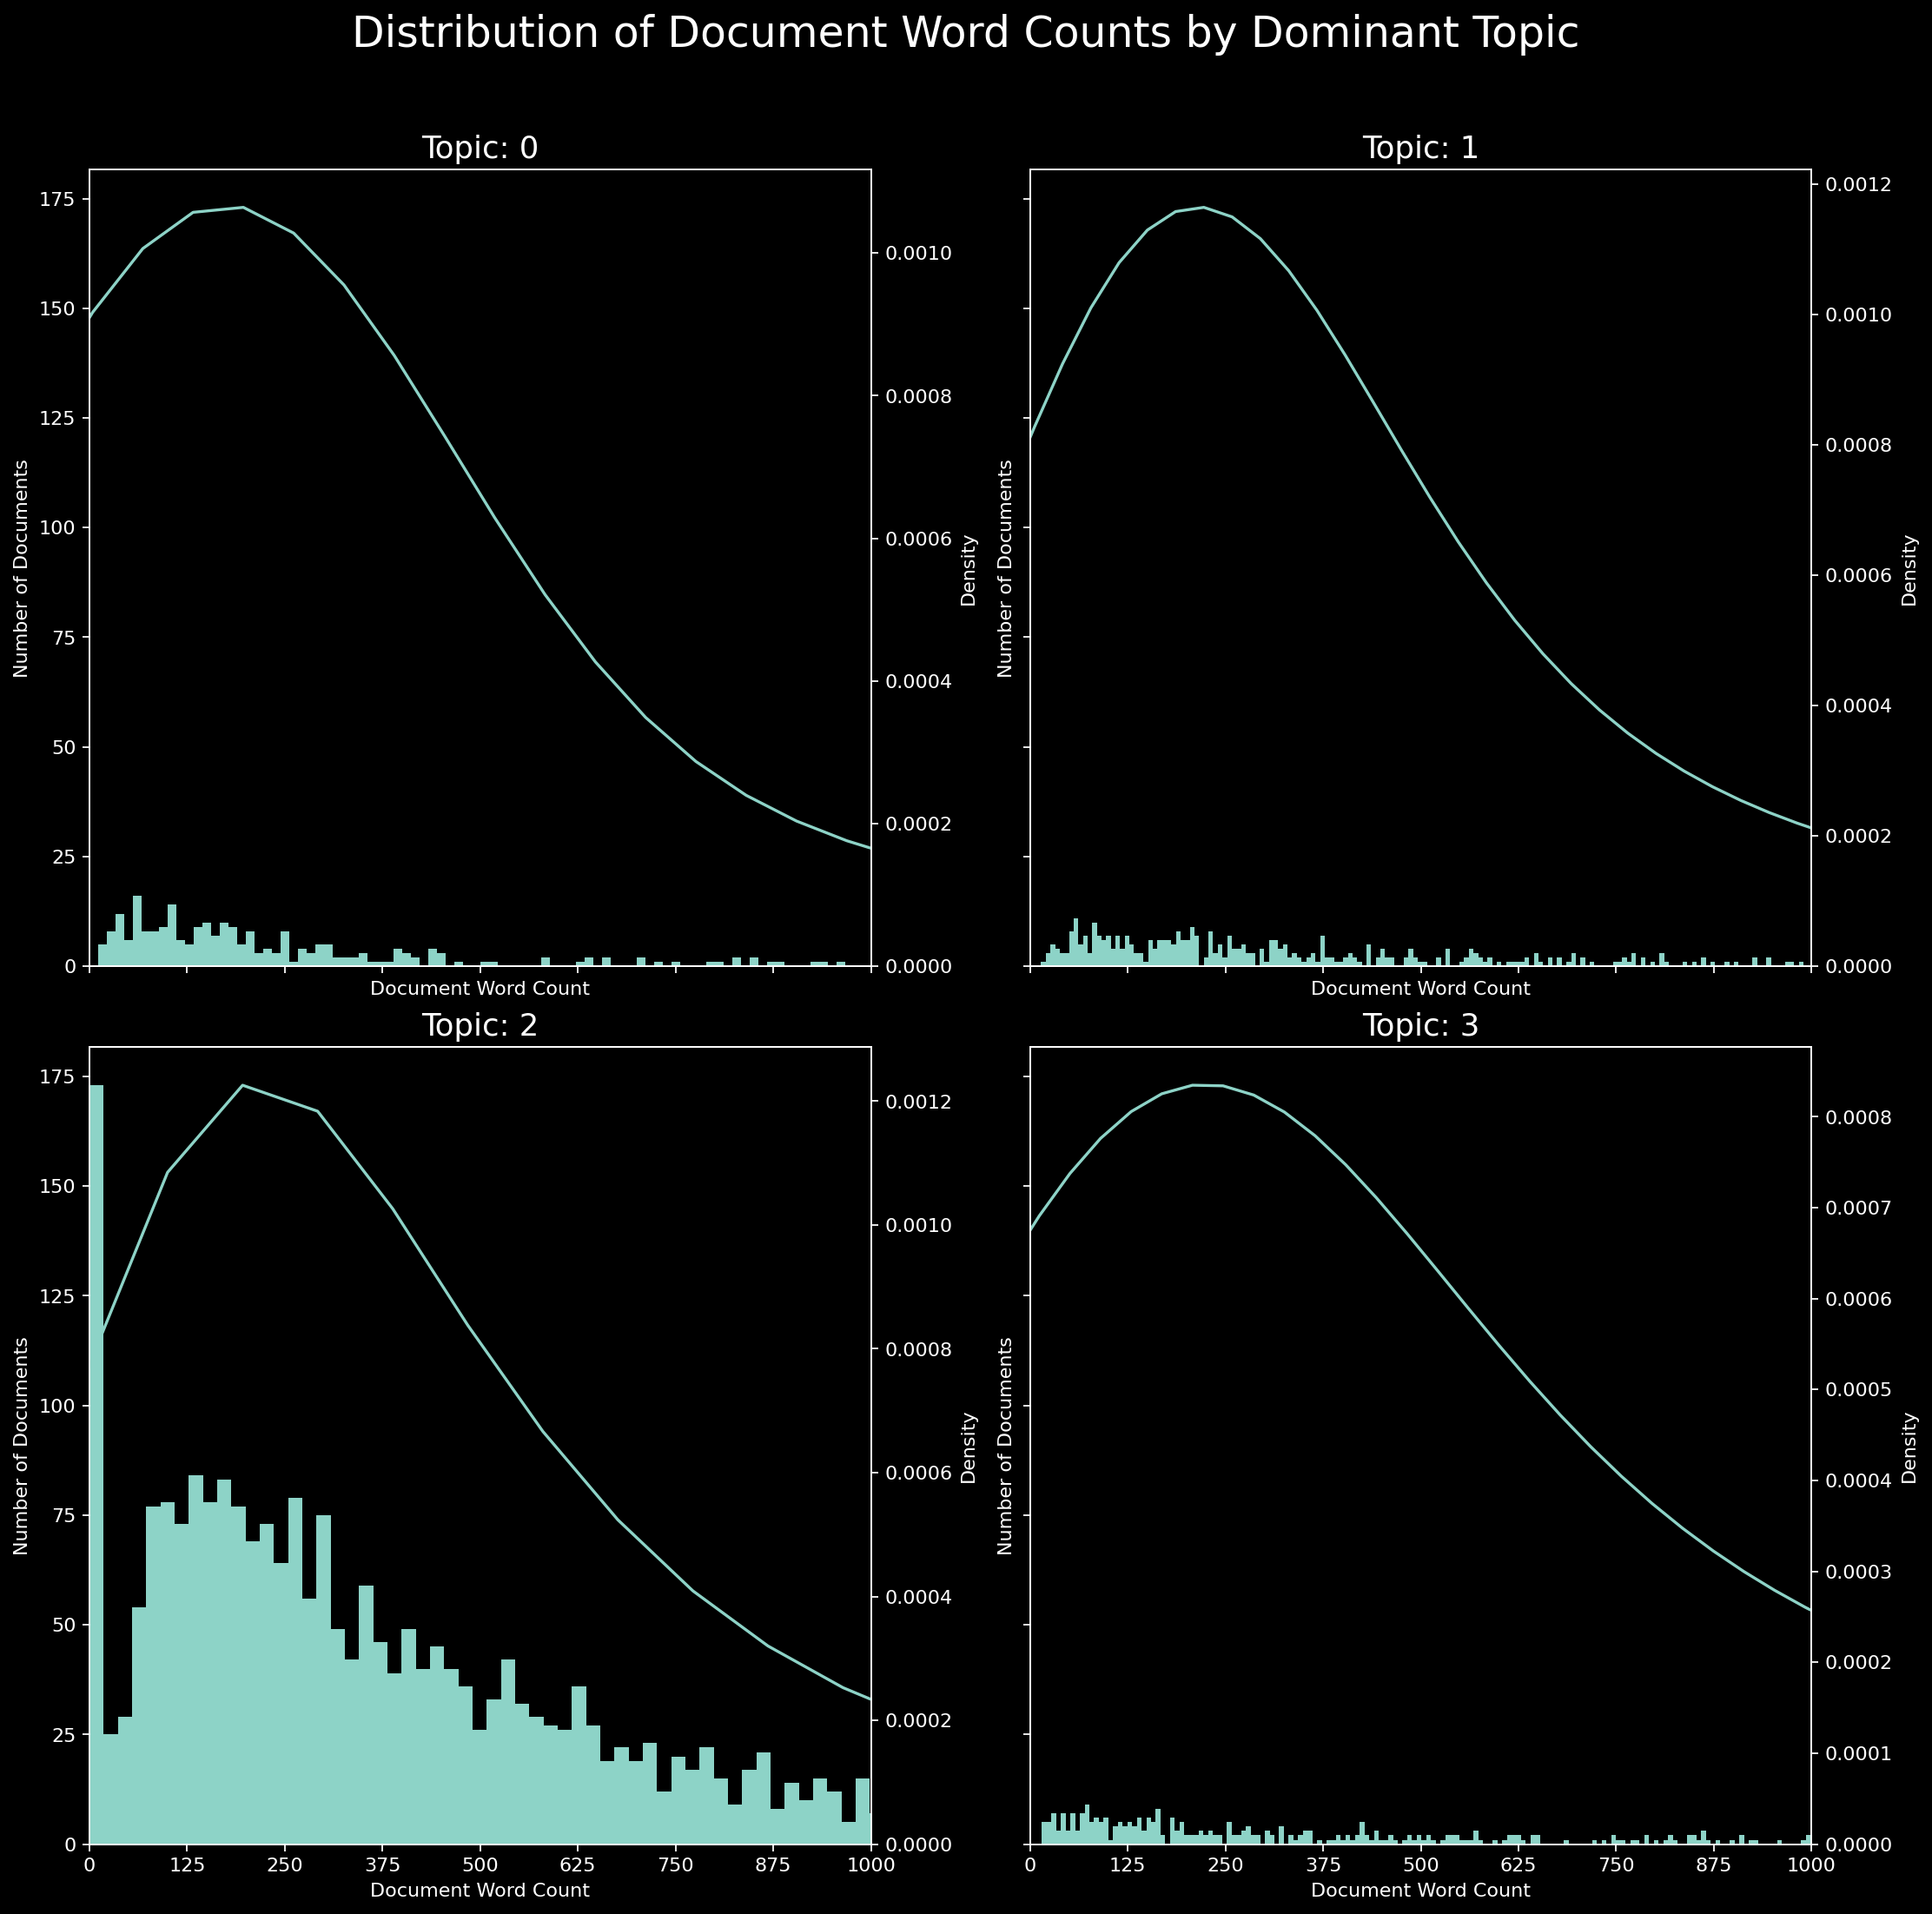

In [11]:
import seaborn as sns

fig, axes = plt.subplots(2,2,figsize=(14,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Email_onderwerp]
    ax.hist(doc_lens, bins = 1000)
    ax.tick_params(axis='y')
    sns.kdeplot(doc_lens, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents')
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Wordcloud of Top N words in each topic

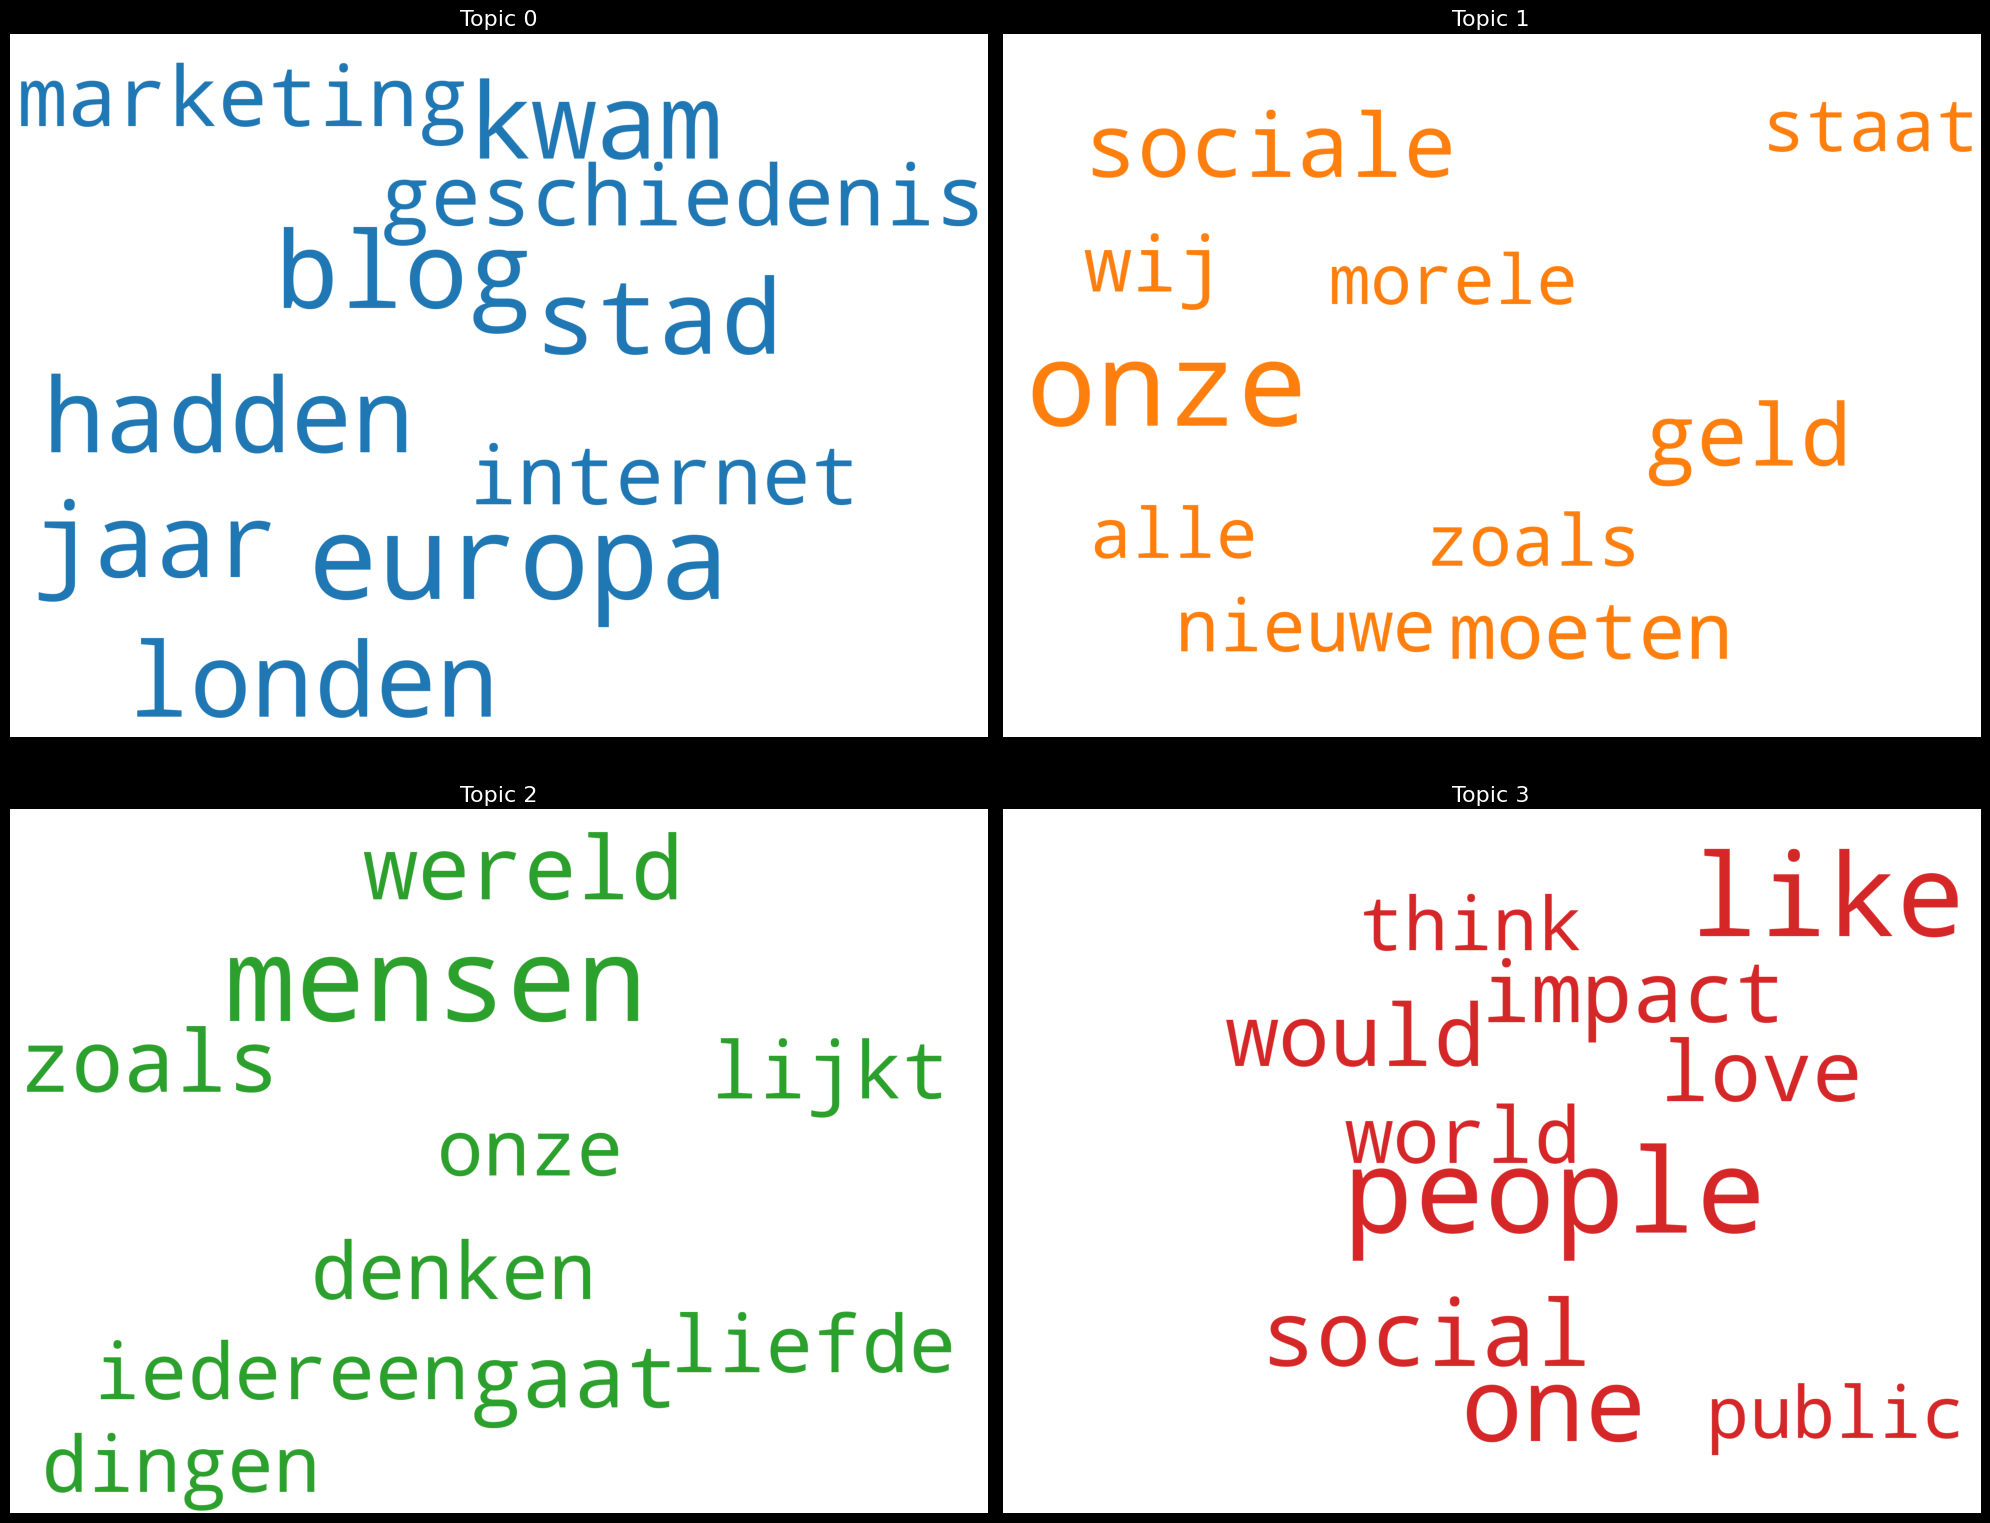

In [12]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Counts of Topic Keywords

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

C:\Users\johan\AppData\Local\Temp\ipykernel_12712\2843463473.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\johan\AppData\Local\Temp\ipykernel_12712\2843463473.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\johan\AppData\Local\Temp\ipykernel_12712\2843463473.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\johan\AppData\Local\Temp\ipykernel_12712\2843463473.py:24: UserWarning: set_ticklabels() should only be used with a

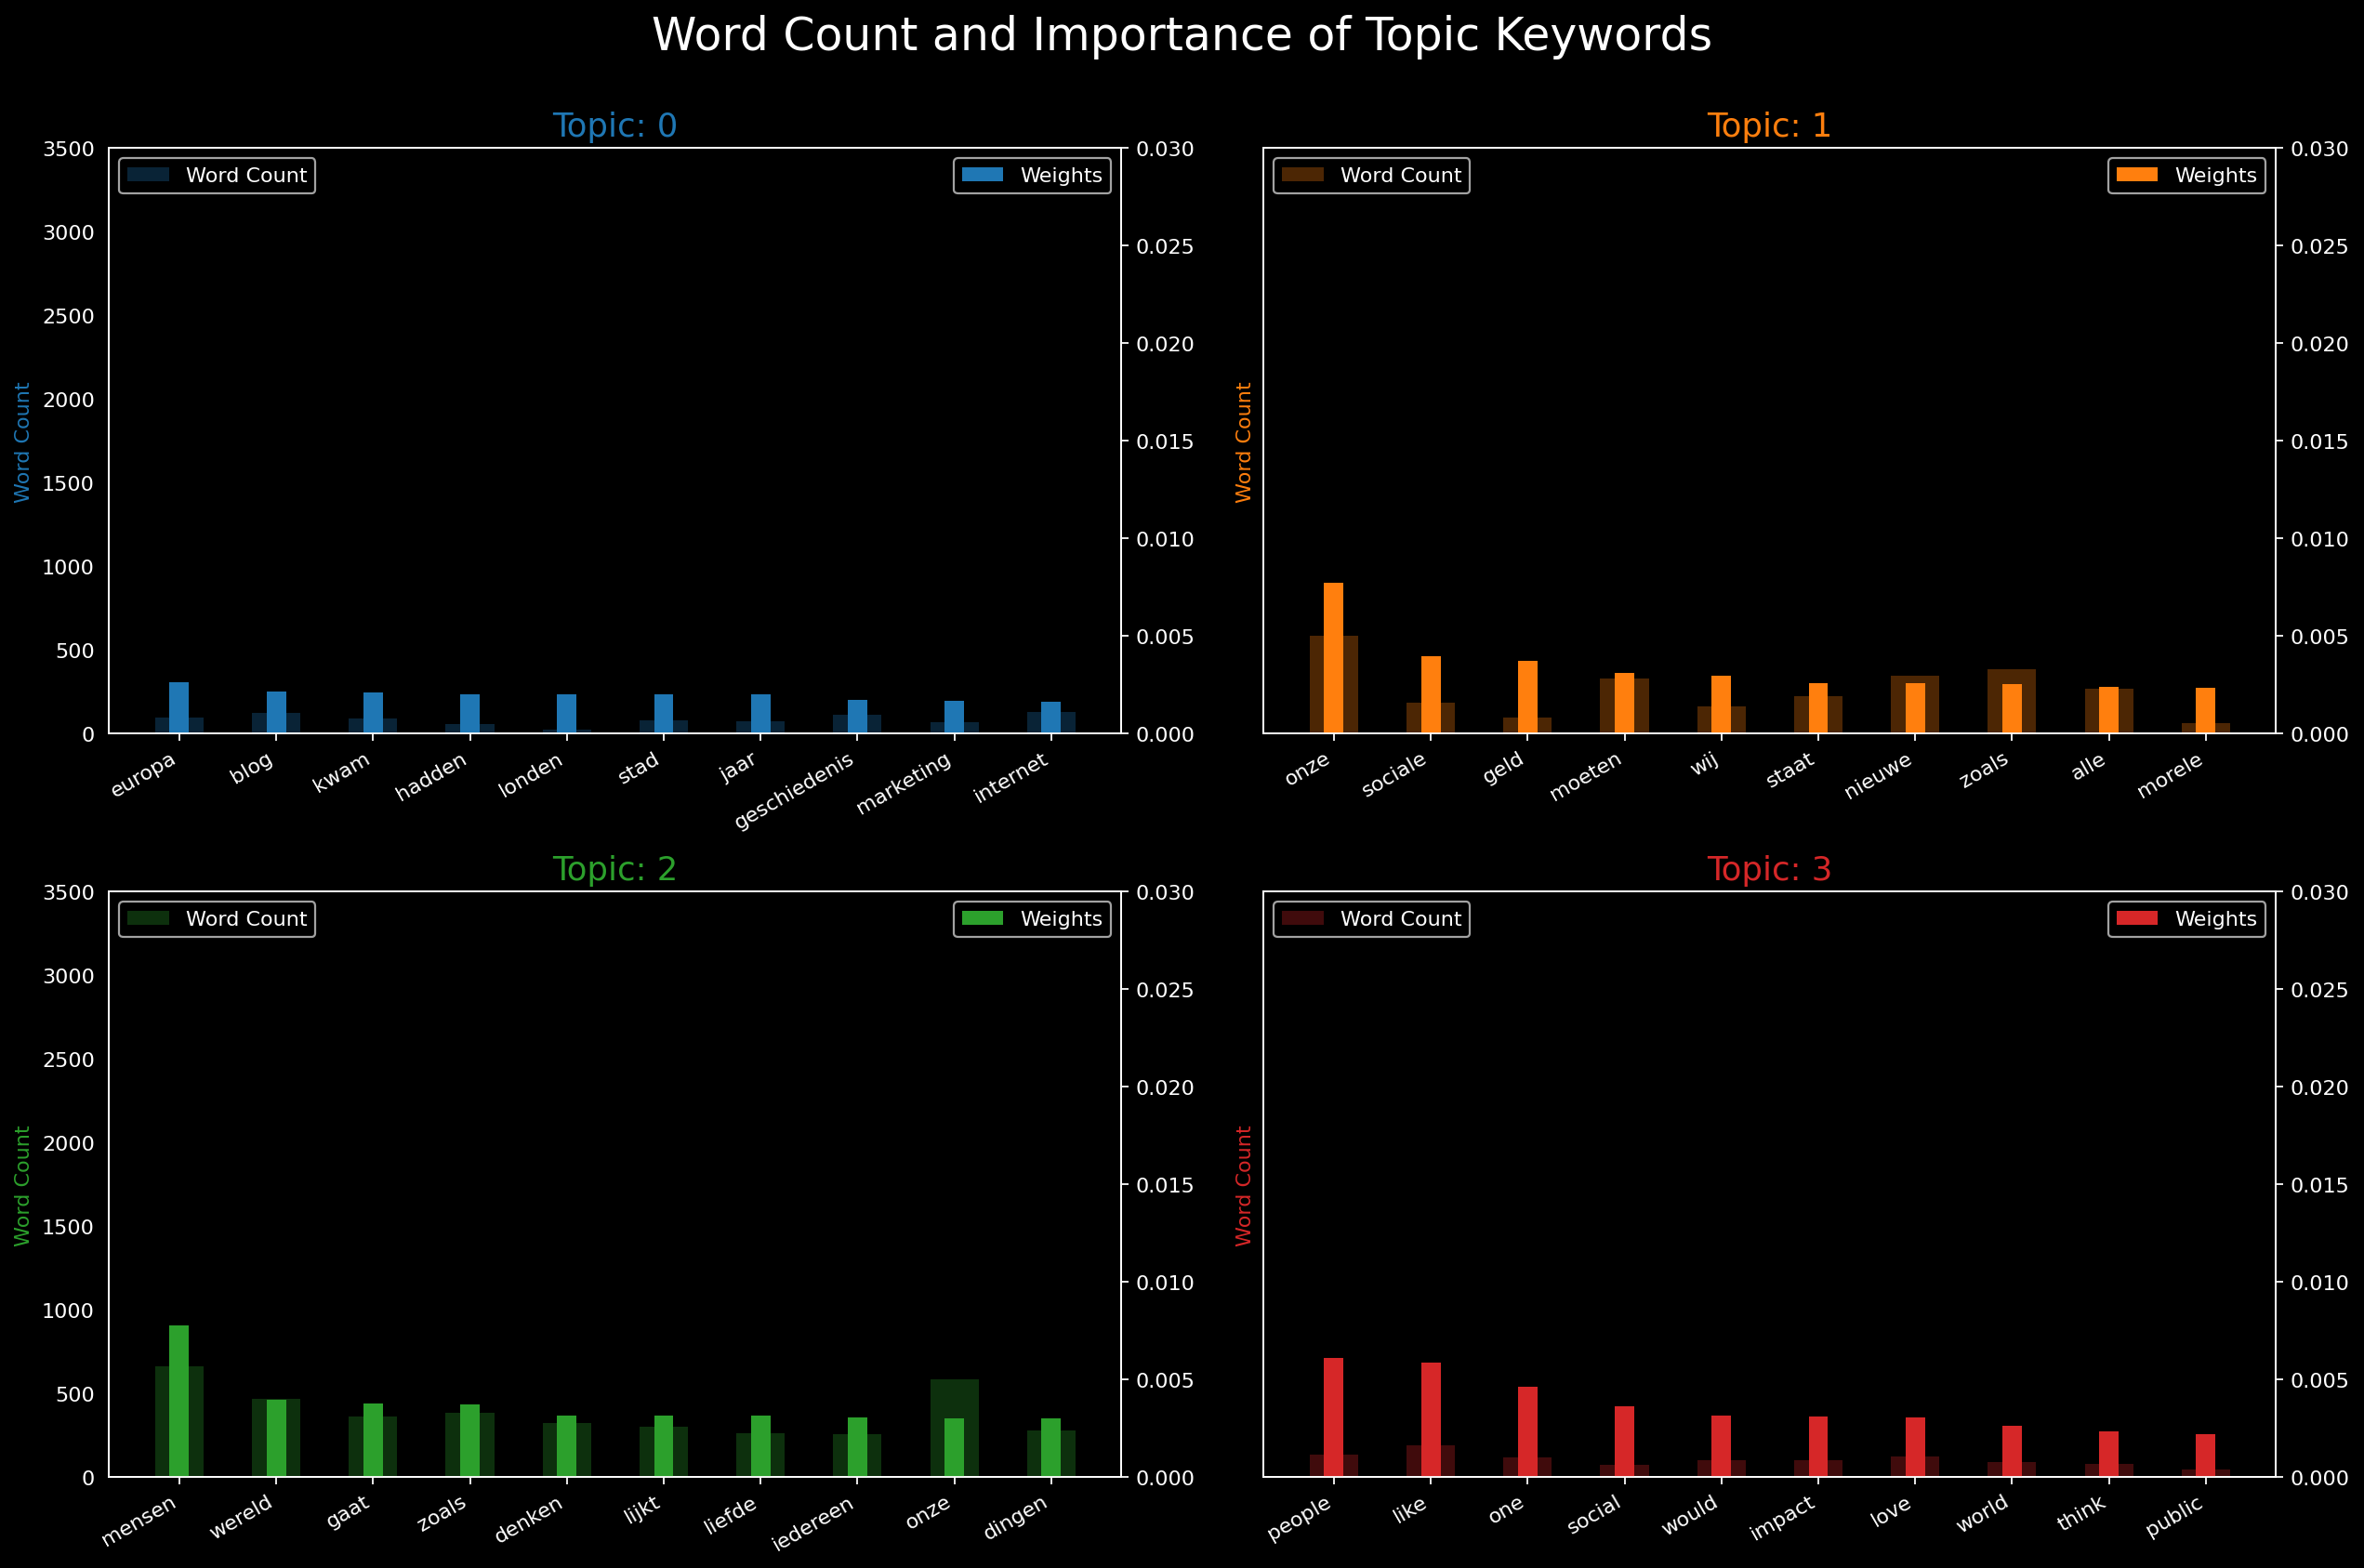

In [13]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2,2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Sentence Chart Colored by Topic

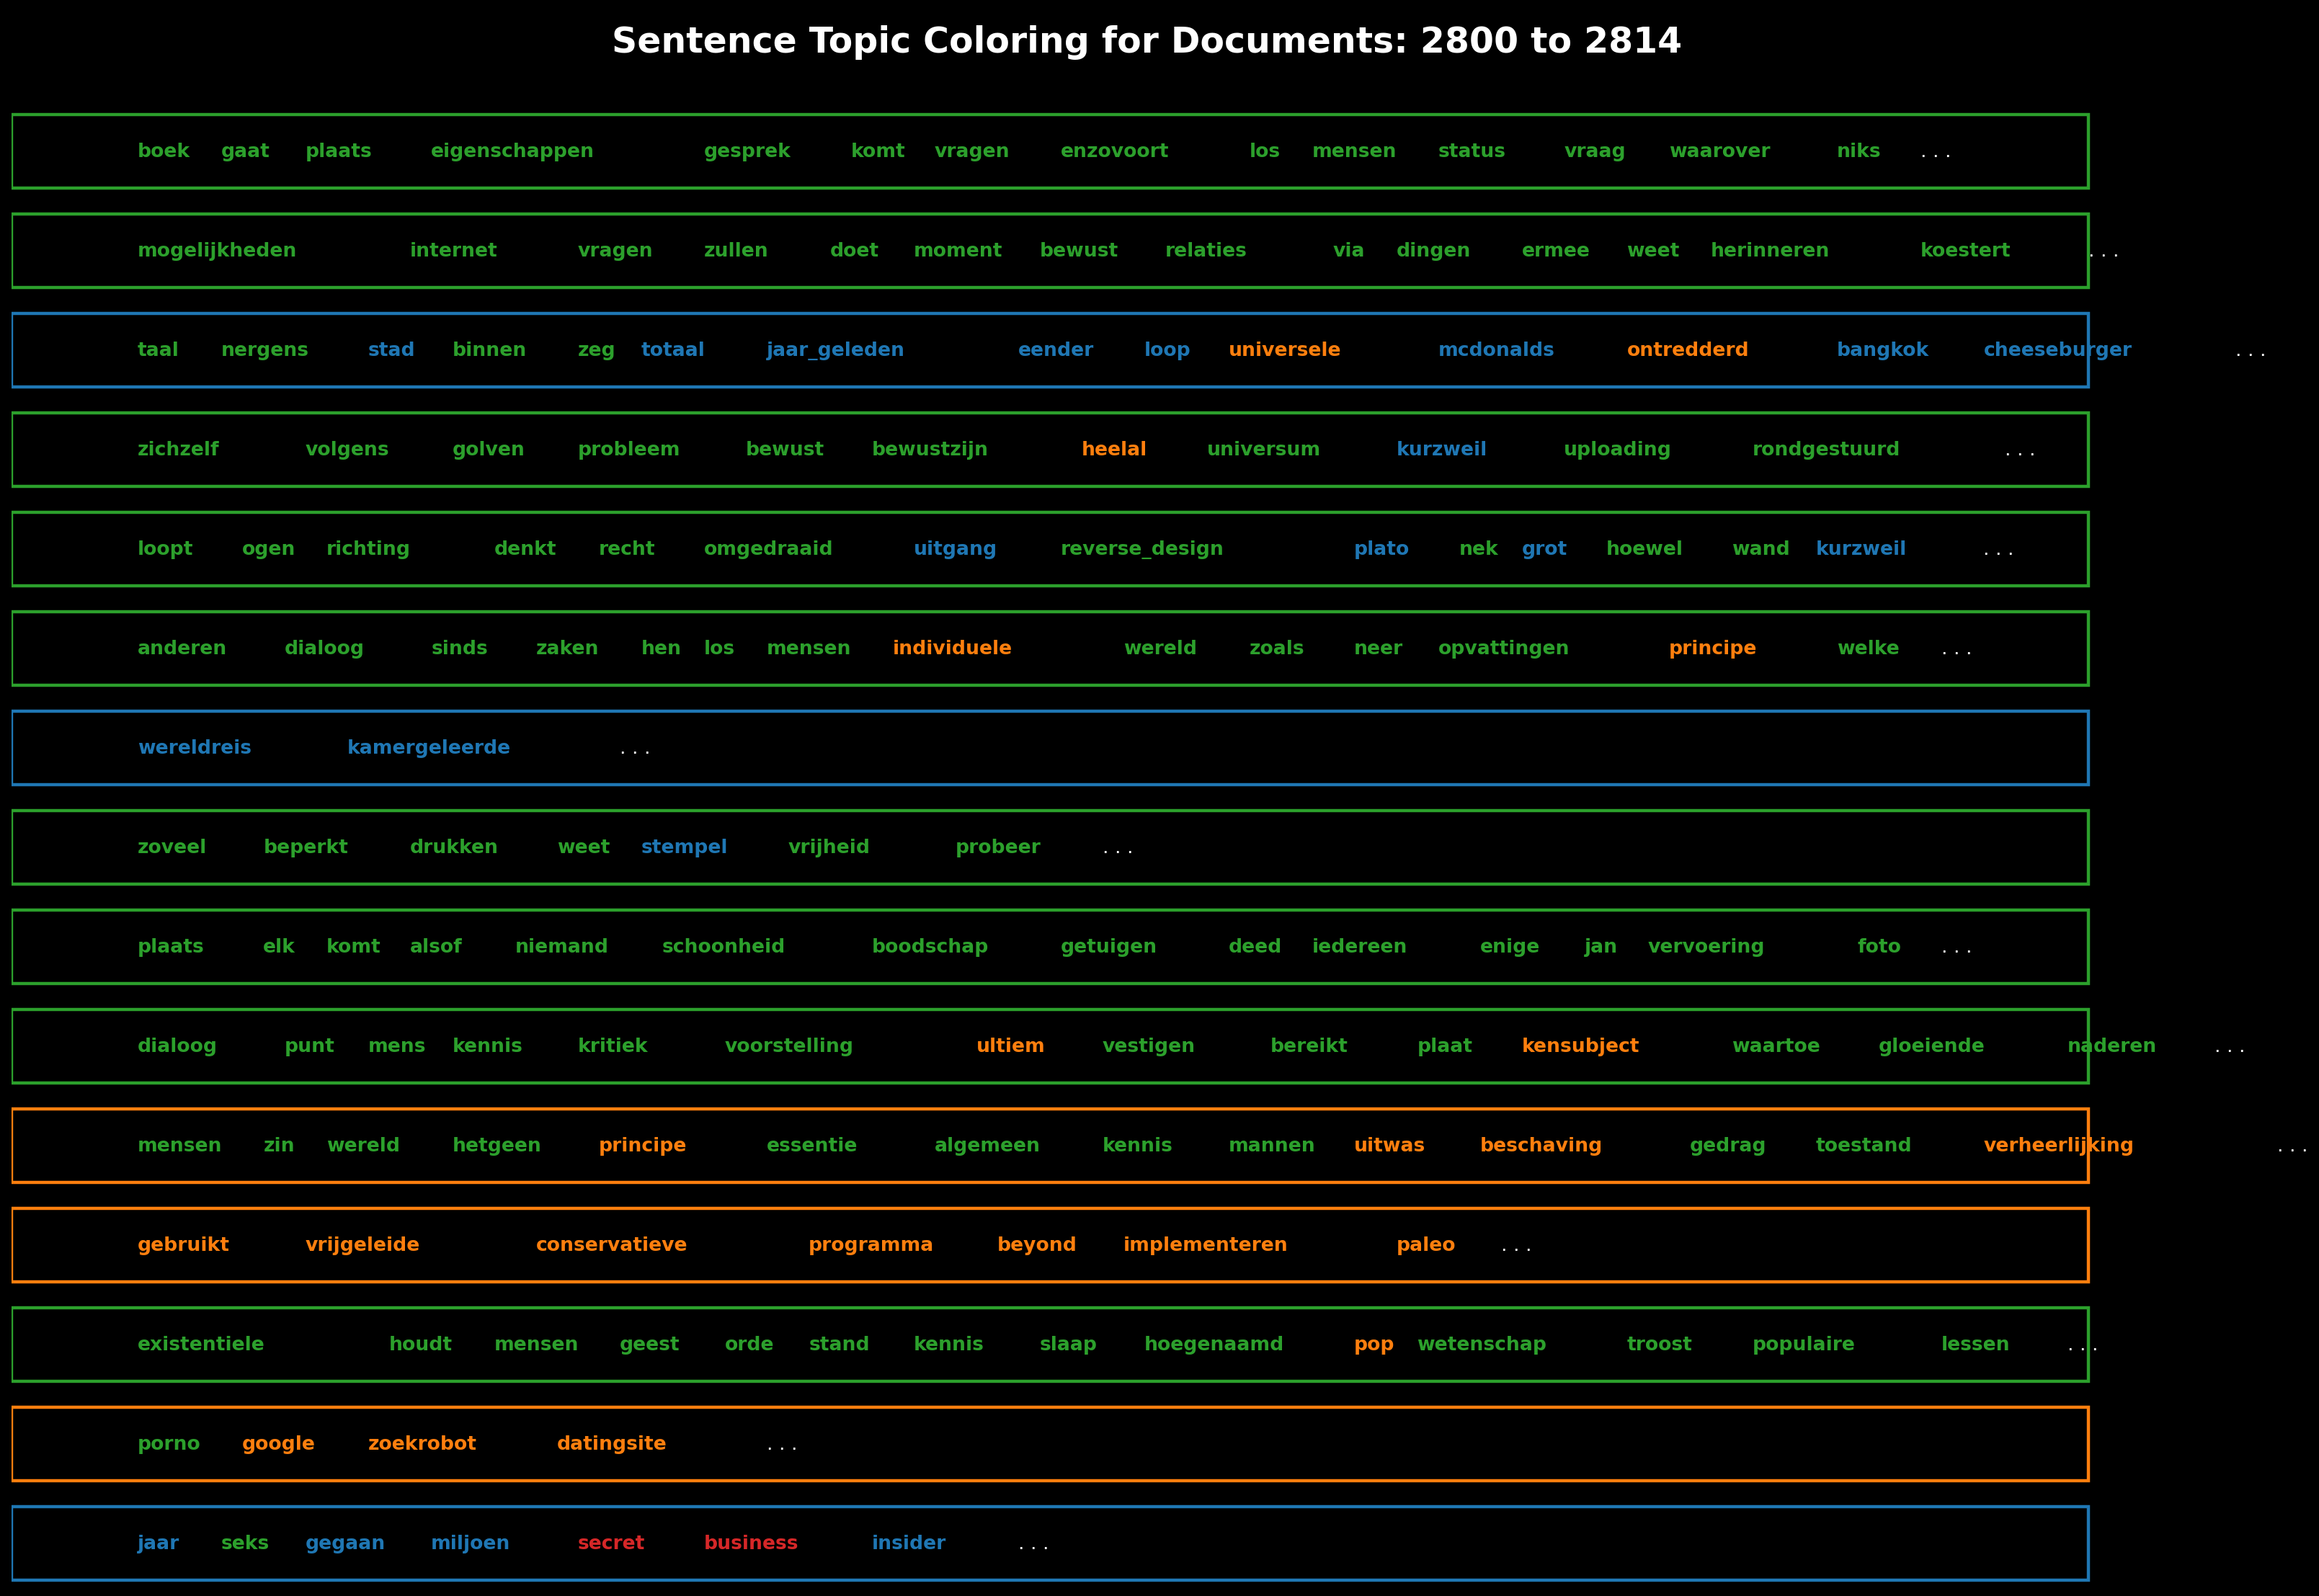

In [14]:
# Sentence Coloring
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.9), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            # ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
            #         fontsize=12, color='white', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .01 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=12, color='white',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(start = 2800, end = 2816)    

## t-SNE Clustering Chart 

- t-distributed Stochastic Neighbor Embedding

In [15]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35] # fucks up the alignment with the other arrays

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [16]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2) #, angle=.99, init='pca') # , perplexity=100, early_exaggeration=25)
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
np.unique(topic_num)

In [17]:
n_topics = 4

In [18]:
from bokeh.models import ColumnDataSource, HoverTool, TapTool, CustomJS, Div
from bokeh.layouts import column

output_notebook()
mycolors = np.array(list(mcolors.TABLEAU_COLORS.values()) + \
         [mcolors.to_hex(c) for c in plt.cm.Pastel1.colors] + \
         [mcolors.to_hex(c) for c in plt.cm.Set1.colors])

source = ColumnDataSource(data=dict(
    x=tsne_lda[:, 0],                     # difference with kmeans data below is that it uses LDA > TSNE instead of TF-IDF > KMEANS > TSNE
    y=tsne_lda[:, 1],
    colors=mycolors[topic_num % len(mycolors)],
    onderwerp=df_grote_word_doc.heading.tolist(),
    description=data_words,
    # keywords = keyword_list
    ))

hover = HoverTool()
hover.tooltips = [("onderwerp", "@onderwerp"),
                #   ("keywords", "@keywords")
                  ]

description_div = Div(text="", width=1200, height=150)

callback = CustomJS(args=dict(source=source, div=description_div), code="""
    const indices = source.selected.indices;
    if (indices.length == 0)
        return;
    const desc = source.data['description'][indices[0]];
    div.text = desc;
""")
tap_tool = TapTool(callback=callback)

plot = figure(tools="wheel_zoom, reset", title=f"t-SNE Clustering of {n_topics} LDA Topics", width=1000, height=700)
plot.add_tools(hover)
plot.add_tools(tap_tool)

plot.scatter('x', 'y', source=source, color='colors')

layout = column(plot, description_div)

show(layout)

Loading BokehJS ...